In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
import mitdeeplearning as mdl
from tqdm import tqdm

import training dataset from mitdeeplearning lib

In [2]:
songs = mdl.lab1.load_training_data()

Found 817 songs in text


Concatinating all the string in the song for a continuos sequencial training data.

In [3]:
songs_joined = ''.join (songs)

In [4]:
songs_joined[:50]

"X:1\nT:Alexander's\nZ: id:dc-hornpipe-1\nM:C|\nL:1/8\nK"

Finding unique char. in the dataset

In [5]:
vocab = sorted (set(songs_joined))

In [6]:
ch2idx = {u:i for i, u in enumerate(vocab)}
idx2ch = np.array(vocab)

Vectorizing the dataset

In [7]:
def vectorize_string (string):
    vectorized_string = np.array ([ch2idx[char] for char in string])
    return vectorized_string

In [8]:
vectorized_song = vectorize_string (songs_joined)

preparing batches for training the model

In [9]:
def get_batch (vectorized_song, seq_length, batch_size):
    n = vectorized_song.shape[0] - 1
    idx = np.random.choice (n-seq_length, batch_size)

    input_batch = [vectorized_song[i : i+seq_length] for i in idx]
    output_batch = [vectorized_song[i+1 : i+seq_length+1] for i in idx]

    x_batch = np.reshape (input_batch, [batch_size, seq_length])
    y_batch = np.reshape (output_batch, [batch_size, seq_length])
    return x_batch, y_batch

Define the lstm layer

In [10]:
def LSTM (rnn_units):
    return tf.keras.layers.LSTM(
        rnn_units,
        return_sequences = True,
        recurrent_initializer = 'glorot_uniform',
        recurrent_activation = 'sigmoid',
        stateful = True
    )

Embedding layer 
It requires that the input data be integer encoded, so that each word is represented by a unique integer
======RNN layer for sequencial data

In [11]:
def build_model (vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape = [batch_size, None]),
        LSTM(rnn_units),
        tf.keras.layers.Dense(vocab_size)
    ])

    return model

In [12]:
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           21248     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [14]:
x, y = get_batch (vectorized_song, seq_length=100, batch_size=32)
pred = model(x)

In [15]:
print (f'Input {x.shape}            output  {pred.shape}')

Input (32, 100)            output  (32, 100, 83)


Getting the sparse_categorical_crossentropy as it utilizes integer targets for categorical classification task

In [16]:
# label true value
# logit predicted value
def compute_loss (label, logit):
    loss = tf.losses.sparse_categorical_crossentropy(label, logit, from_logits=True)
    return loss

In [17]:
example_loss = compute_loss (y, pred)
print ('Loss: ', example_loss.numpy().mean())

Loss:  4.417592


In [18]:
# Hyperparameter and optimizer setting

#optimization parameters:
num_train_iter = 2000
batch_size = 4
seq_length = 100
learn_rate = 5e-3

#model parameters:
vocab_size = len (vocab)
embedding_dim = 256
rnn_units = 1024

# checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'my_ckpt')


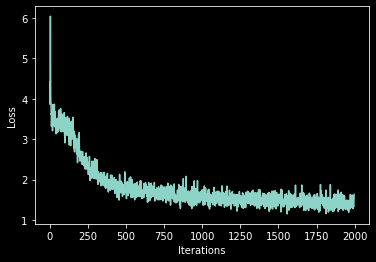

100%|██████████| 2000/2000 [49:21<00:00,  1.48s/it]


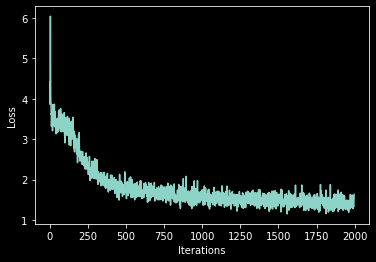

In [19]:
model = build_model (vocab_size, embedding_dim, rnn_units, batch_size)

optimizer = tf.keras.optimizers.Adagrad(learn_rate)

def train_step(x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x)

        loss = compute_loss (y, y_hat)

        grads = tape.gradient (loss, model.trainable_variables)

        optimizer.apply_gradients (zip(grads, model.trainable_variables))

        return loss

history = list()

plotter = mdl.util.PeriodicPlotter (sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr (tqdm, '_instances'): tqdm._instances.clear()

for iter in tqdm (range(num_train_iter)):
    
    x_batch, y_batch = get_batch (vectorized_song, seq_length, batch_size)
    loss = train_step (x_batch, y_batch)

    history.append (loss.numpy().mean())
    plotter.plot(history)

    if iter%100 == 0:
        model.save_weights(checkpoint_prefix)
    model.save_weights(checkpoint_prefix)

Remaking the model to run a different batch_size (1)
restore the weights from the latest checkpoint

In [33]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) 

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_3 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


The prediction procedure

In [34]:

def generate_text(model, start_string, generation_length=1000):

  input_eval = [ch2idx[s] for s in start_string] # TODO
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []

  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      
      predictions = tf.squeeze(predictions, 0)
      
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2ch[predicted_id])
    
  return (start_string + ''.join(text_generated))

In [35]:
generate_text = generate_text (model, start_string='X', generation_length=1000)

100%|██████████| 1000/1000 [00:30<00:00, 32.89it/s]


In [36]:
generated_songs = mdl.lab1.extract_song_snippet(generate_text)

for i, song in enumerate(generated_songs): 
  waveform = mdl.lab1.play_song(song)

  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

Found 0 songs in text
